In [11]:
import pandas as pd 
from scipy.sparse import load_npz

from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt




import joblib

## Load processed dataset

In [12]:
# Load the sparse matrix
X_resampled_loaded = load_npz('../data/processed/X_resampled.npz')

# Load the target variable
y_resampled_loaded = pd.read_csv('../data/processed/y_resampled.csv').values.flatten()

#Load the test set

X_test = load_npz('../data/processed/X_test.npz')
y_test = pd.read_csv('../data/processed/y_test.csv')

## Train the model with GridSearchCV

In [13]:
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
model = MultinomialNB()
clf = GridSearchCV(model, parameters,cv=10, n_jobs=-1)
clf.fit(X_resampled_loaded, y_resampled_loaded)

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]})

In [14]:
print(clf.best_params_)
print(clf.best_score_)

{'alpha': 0.1}
0.9928734542308788


## Test and evaluation

In [15]:
train_accuracy = clf.score(X_resampled_loaded, y_resampled_loaded)
test_accuracy = clf.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9947468958930277
Test Accuracy: 0.9896532438478747


In [16]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [17]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)       # Calculate the accuracy
report = classification_report(y_test, y_pred)  # Get the precision, recall, f1-score

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3403
           1       0.87      0.92      0.90       173

    accuracy                           0.99      3576
   macro avg       0.93      0.96      0.95      3576
weighted avg       0.99      0.99      0.99      3576



In [18]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1]) 
print(conf_matrix)

[[3379   24]
 [  13  160]]


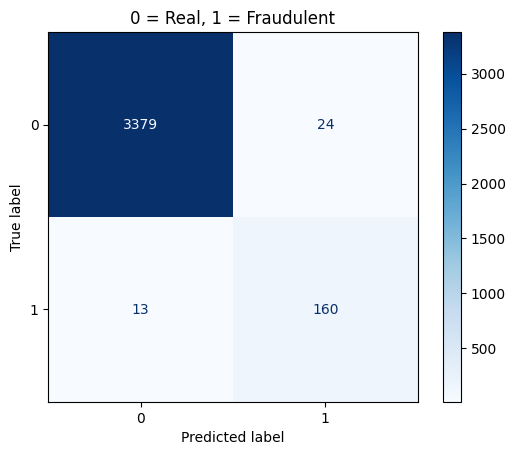

In [19]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("0 = Real, 1 = Fraudulent")
plt.show()

## Save the model

In [20]:
best_model = clf.best_estimator_
joblib.dump(best_model, '../models/modelMNB_v2.pkl')


['../models/modelMNB_v2.pkl']